<a href="https://colab.research.google.com/github/bartoszkozakiewicz/MachineLearning/blob/main/PurchasePrediction_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem** - Can you predict whether a website visitor is likely to purchase?

I understand this problem as if based on data that is given such as: timeOnSite, pageviews.., model has to predict whether that customer (row in dataset) is likely to purchase. Then number of transactions during session can be exchanged just to made_transaction (Crucial in this question - Is likely to purchase, apart from number of transactions during session): 
- if transactions>0 then made_transaction=1
- if transactions=0 then made_transaction=0

And that will be y_label -> label to predict.

I have made that assumption because of the fact that there is no question about customers who have returned (Not first visit) and then are likely to purchase.

So I assume that purpose can be to explore all situations without emphasis on purchases made by customers after returning to website. 

#Imports and essential settings

In [ ]:
#Getting access to google account and data in bigquery
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'delvetesttask'
client = bigquery.Client(project=project)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import shap

# 0 Create dataframes for exploratory and future predictions making

**Capture data from SQL with sql query**

After analyzing and studying various features in the database I have decided to select features seen below in the SQL query due to the fact that I consider them to be the most relevant and possibly related to customer purchasing behavior. However, for a more in-depth analysis of less obvious data, Principal Component Analysis could be employed to explore the impact of the data on variability. This could provide additional insight and help in understanding the data present in the database.

Also some of features which I considered to be valuable are filled with NaN, like AddGroupId or are no such features in database despite the fact that there are in describtion of database features. 

In [ ]:
#AddGroupId are only Null values, so that's useless
initial_data_query = """
SELECT 

fullVisitorId,
date,
visitStartTime,
IFNULL(totals.bounces, 0) AS bounces,
IFNULL(totals.timeOnSite,0) AS timeOnSite,
IFNULL(totals.pageviews,0) AS pageviews,
totals.hits AS num_of_hits,
IFNULL(totals.newVisits, 0) AS is_first_visit,
device.deviceCategory AS device,
geoNetwork.country AS country,
trafficSource.source AS source,
channelGrouping,

IFNULL(totals.transactions,0) AS transactions

FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`;
"""

In [ ]:
df = client.query(initial_data_query).result().to_dataframe()
#For compatibility with numpy change to int64 type
df["date"] = df["date"].astype(int)
df["visitStartTime"] = df["visitStartTime"].astype(int)
df["bounces"] = df["bounces"].astype(int)
df["timeOnSite"] = df["timeOnSite"].astype(int)
df["pageviews"] = df["pageviews"].astype(int)
df["num_of_hits"] = df["num_of_hits"].astype(int)
df["is_first_visit"] = df["is_first_visit"].astype(int)

#Create y label -> if some transactions during training made 1, else 0
df["transaction_made"] = df["transactions"].apply(lambda x: 1 if x>=1 else 0)
df.head()

,fullVisitorId,date,visitStartTime,bounces,timeOnSite,pageviews,num_of_hits,is_first_visit,device,country,source,channelGrouping,transactions,transaction_made
0,3989740855378994428,20170614,1497455649,0,129,8,14,1,desktop,United States,google,Organic Search,0,0
1,4053276322918776588,20170614,1497456388,0,641,13,14,1,mobile,Taiwan,google,Organic Search,0,0
2,0067566216922331849,20170614,1497476332,0,385,12,14,0,desktop,United States,(direct),Referral,1,1
3,4995584940873803432,20170614,1497463936,0,168,10,14,0,desktop,United States,google,Organic Search,0,0
4,312563032232212298,20170614,1497462978,0,687,10,14,0,mobile,United States,google,Organic Search,0,0


# 1 Exploratory data analysis 

In [ ]:
#Get basic information about created dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   fullVisitorId     903653 non-null  object
 1   date              903653 non-null  int64 
 2   visitStartTime    903653 non-null  int64 
 3   bounces           903653 non-null  int64 
 4   timeOnSite        903653 non-null  int64 
 5   pageviews         903653 non-null  int64 
 6   num_of_hits       903653 non-null  int64 
 7   is_first_visit    903653 non-null  int64 
 8   device            903653 non-null  object
 9   country           903653 non-null  object
 10  source            903653 non-null  object
 11  channelGrouping   903653 non-null  object
 12  transactions      903653 non-null  Int64 
 13  transaction_made  903653 non-null  int64 
dtypes: Int64(1), int64(8), object(5)
memory usage: 97.4+ MB


In [ ]:
#Check some statistics of continuous data
df.describe()

,date,visitStartTime,bounces,timeOnSite,pageviews,num_of_hits,is_first_visit,transactions,transaction_made
count,9.036530e+05,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.0,903653.000000
mean,2.016589e+07,1485007290.059528,0.498676,131.325687,3.849338,4.596538,0.77802,0.013407,0.012784
std,4.697698e+03,9022123.679186,0.499999,367.584534,7.025002,9.641437,0.415578,0.128574,0.112340
min,2.016080e+07,1470034812.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
25%,2.016103e+07,1477561169.0,0.0,0.0,1.0,1.0,1.0,0.0,0.000000
50%,2.017011e+07,1483948934.0,0.0,1.0,1.0,2.0,1.0,0.0,0.000000
75%,2.017042e+07,1492758762.0,1.0,84.0,4.0,4.0,1.0,0.0,0.000000
max,2.017080e+07,1501657193.0,1.0,19017.0,469.0,500.0,1.0,25.0,1.000000


**Check if there aren't any null values left**

In [ ]:
df.isnull().sum()

fullVisitorId       0
date                0
visitStartTime      0
bounces             0
timeOnSite          0
pageviews           0
num_of_hits         0
is_first_visit      0
device              0
country             0
source              0
channelGrouping     0
transactions        0
transaction_made    0
dtype: int64

In [ ]:
#For some general analysis of features between those where transaction was made or no 
df.groupby("transaction_made").describe().transpose()

transaction_made                  0                1
date         count         892101.0          11552.0
             mean   20165881.119973  20166204.566049
             std        4697.660144      4689.790189
             min         20160801.0       20160801.0
             25%         20161027.0       20161101.0
...                             ...              ...
transactions min                0.0              1.0
             25%                0.0              1.0
             50%                0.0              1.0
             75%                0.0              1.0
             max                0.0             25.0

[64 rows x 2 columns]

**Explore unique values in dataframe columns**
- device
- country
- source
-channelGrouping

In [ ]:
devices = df["device"].unique()
channelgroupings = df["channelGrouping"].unique()
countries = df["country"].sort_values().unique()
sources = df["source"].sort_values().unique()
print(f"Devices: {devices},\nChannel Groupings: {channelgroupings}\nCountries: {countries}\nSources: {sources}")

Devices: ['desktop' 'mobile' 'tablet'],
Channel Groupings: ['Direct' 'Display' 'Referral' 'Organic Search' 'Affiliates' 'Paid Search'
 'Social' '(Other)']
Countries: ['(not set)' 'Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra'
 'Angola' 'Anguilla' 'Antigua & Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia' 'Bosnia & Herzegovina' 'Botswana' 'Brazil'
 'British Virgin Islands' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde' 'Caribbean Netherlands'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo - Brazzaville' 'Congo - Kinshasa'
 'Cook Islands' 'Costa Rica' 'Croatia' 'Curaçao' 'Cyprus' 'Czechia'
 'Côte d’Ivoire' 'Denmark' 'Djibouti' 'Dominica' 'Dominican Republic'
 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia'
 'Ethiopia' 'Far

**Correlation heatmap**
- Correlation between continous data

<ipython-input-74-17d14053586a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.drop("transactions",axis=1).corr(),annot=True,cmap="viridis");


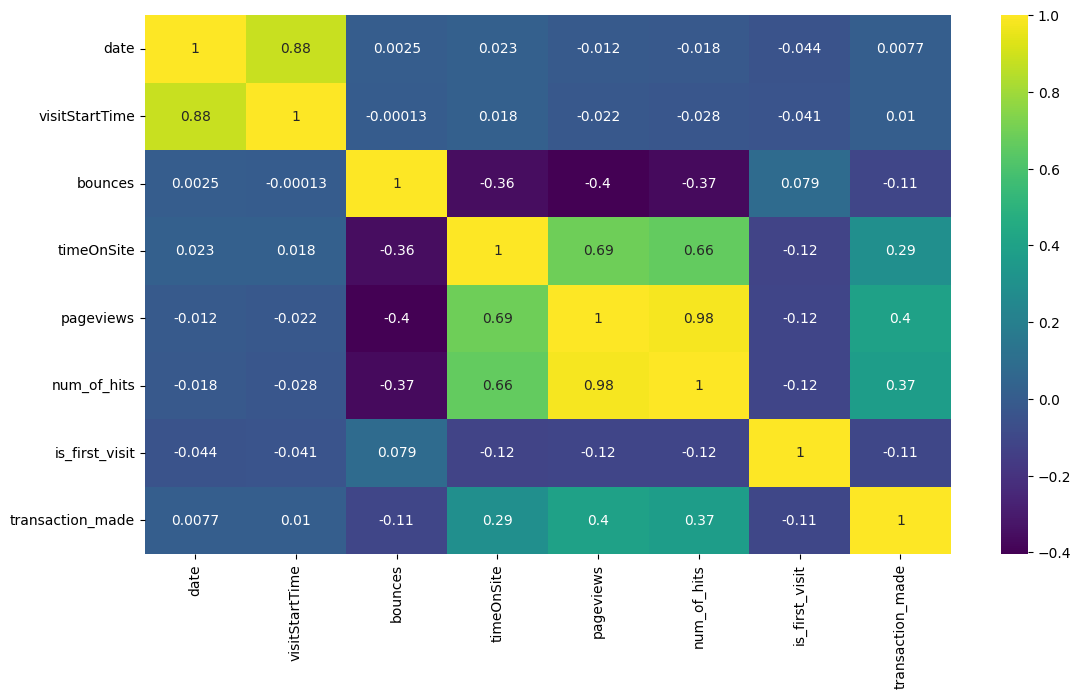

In [ ]:
plt.figure(figsize=(13,7))
sns.heatmap(df.drop("transactions",axis=1).corr(),annot=True,cmap="viridis");

**Sorted correlations between transaction_made and continuous data**

<ipython-input-133-175dab394ad9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = df.drop(["transactions"],axis=1).corr()["transaction_made"].sort_values(ascending=False)[1:].plot(kind='bar');


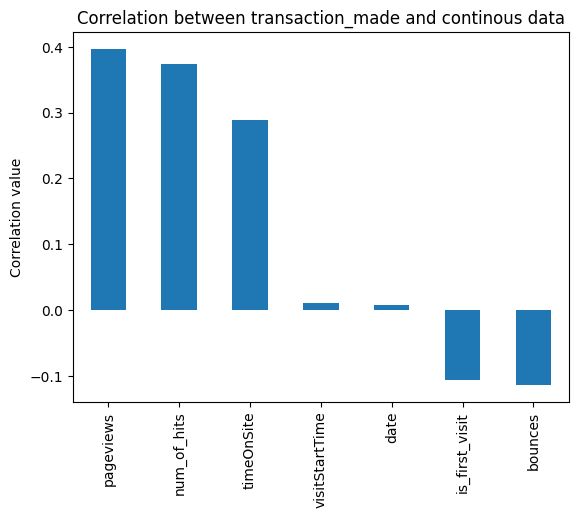

In [ ]:
#Take features to barplot except from transaction_made 
ax = df.drop(["transactions"],axis=1).corr()["transaction_made"].sort_values(ascending=False)[1:].plot(kind='bar');
ax.set_title("Correlation between transaction_made and continous data");
ax.set_ylabel("Correlation value");

**Pairplot**
- To overall analyse relations beetwen continuous data and search for some patterns with ylabel also (hue="transaction_made")

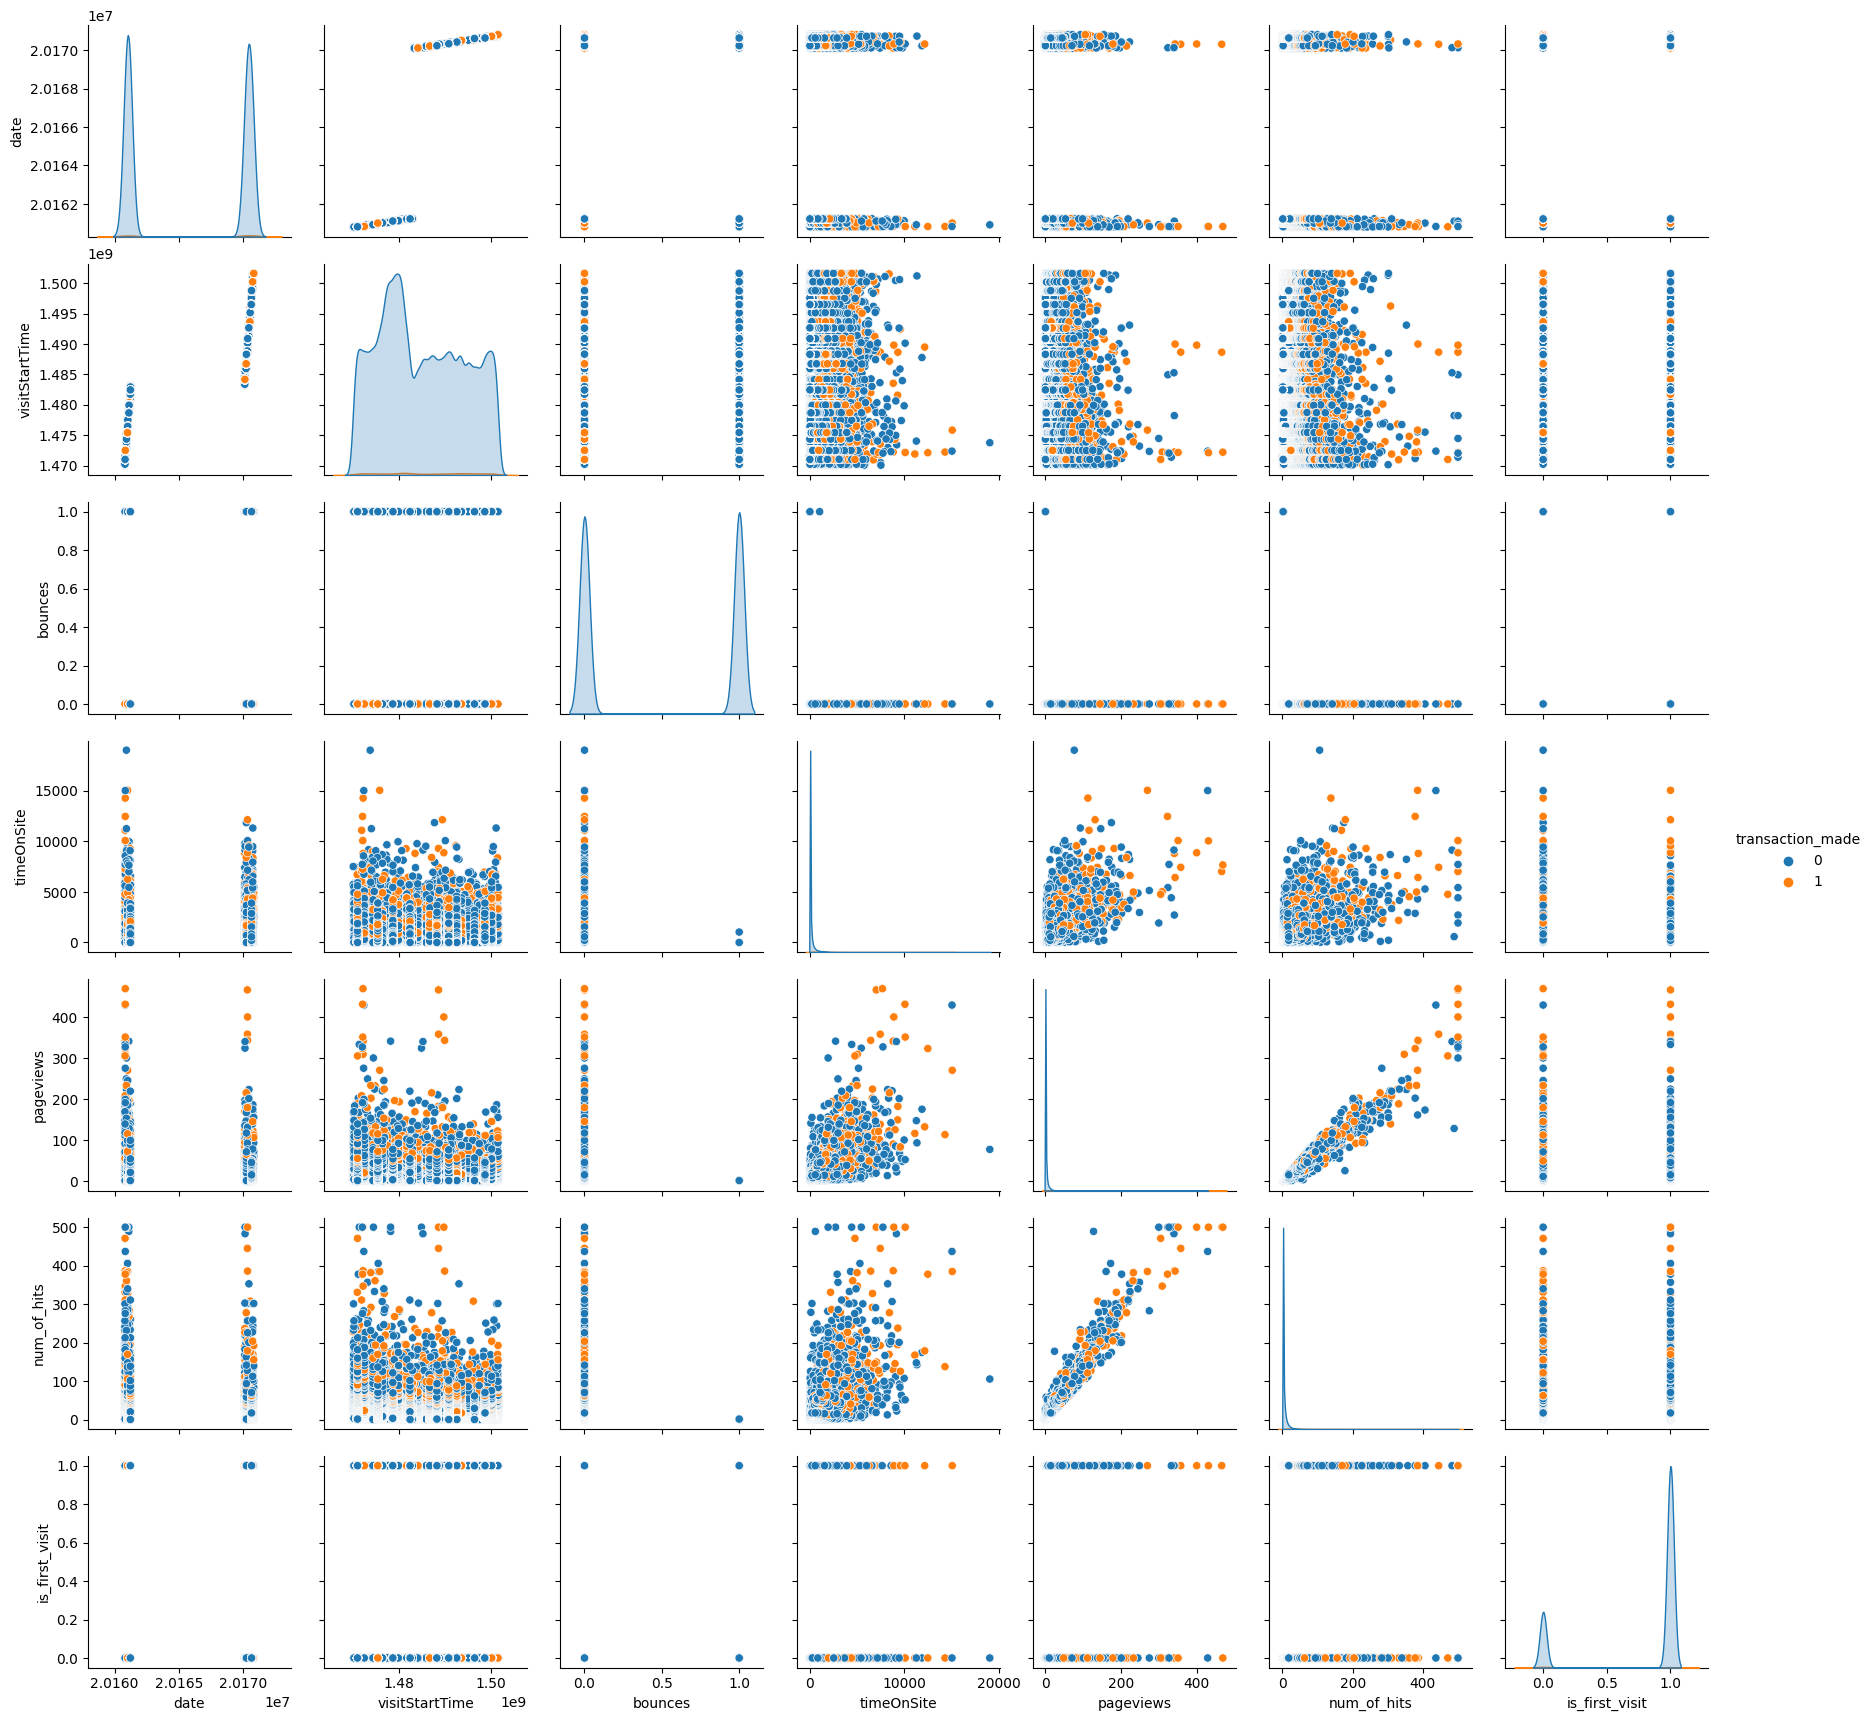

In [ ]:
sns.pairplot(df.drop("transactions",axis=1),hue="transaction_made")

**In what percentage of visits transaction was made?**

In [ ]:
#Extract sessions with transactions and without transactions and calculate percentage
no_transactions = df["transaction_made"].value_counts()[0]
transactions = df["transaction_made"].value_counts()[1]
transaction_percent = 100*transactions / (no_transactions+transactions)

print(f"Percentage of transactions made: {round(transaction_percent,3)}%\nNumber of visits without transaction: {no_transactions}\nNumber of visits with transaction: {transactions}")


Percentage of transactions made: 1.278%
Number of visits without transaction: 892101
Number of visits with transaction: 11552


There is huge imbalance in target value "transaction" which will be crucial during prediction part.

**What percentage of visitors made transaction?**

In [ ]:
#Extract sessions for unique visitors by grouping by fullVisitorId and calcualate number of visitors with/without transactions
visitors_without_transaction = df.groupby("fullVisitorId").transaction_made.sum().value_counts()[0]
visitors_with_transactions = sum(df.groupby("fullVisitorId").transaction_made.sum().value_counts()[1:])
percentage_of_visitors_with_transactions = 100*visitors_with_transactions/(visitors_with_transactions+visitors_without_transaction)

print(f"Percentage of visitors with transactions: {round(percentage_of_visitors_with_transactions,3)}%\nVisitors with transactions: {visitors_with_transactions}\nVisitors without transactions: {visitors_without_transaction}")

Percentage of visitors with transactions: 1.403%
Visitors with transactions: 10022
Visitors without transactions: 704145


**Trace connection between first visit and transaction making**

Precentage of transaction made during first visits vs all first visits: 0.637%
Precentage of transaction making during next visits vs all next visits:3.528%


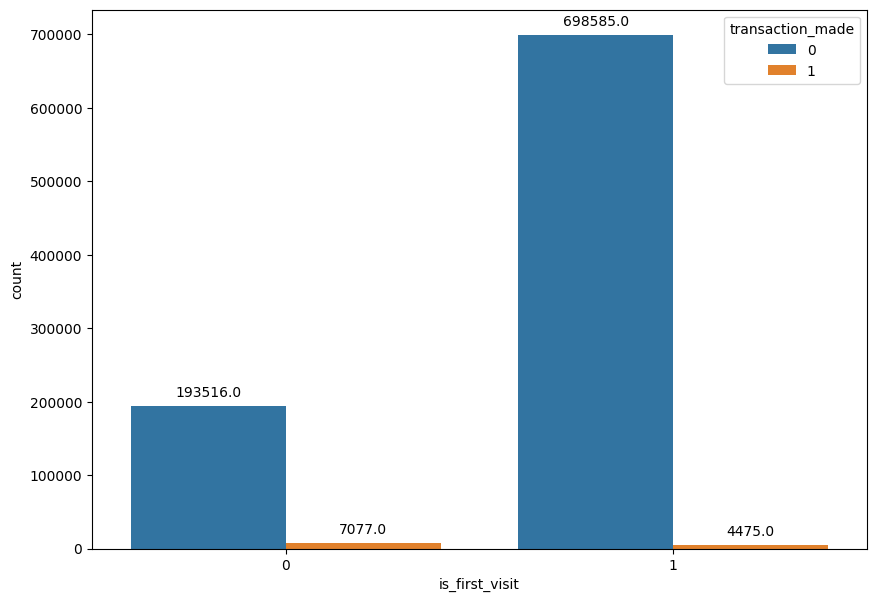

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.countplot(df,x="is_first_visit",hue="transaction_made");
#Including heights above each column on countplot for better understanding
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
#Getting columns height to calculate percentage of transaction making
visit0_transaction0 = ax.patches[0].get_height()
visit0_transaction1 = ax.patches[2].get_height()
visit1_transaction0 = ax.patches[1].get_height()
visit1_transaction1 = ax.patches[3].get_height()
#Calculating and presenting percentage of transactions made on first or next visits
print(f"Precentage of transaction made during first visits vs all first visits: {round(100*visit1_transaction1/(visit1_transaction0+visit1_transaction1),3)}%\nPrecentage of transaction making during next visits vs all next visits:{round(100*visit0_transaction1/(visit0_transaction0+visit0_transaction1),3)}%")

There can be seen some relation between first visit and transaction making - there are relatively more transactions made during next visits. 

**Trace connection between device and transaction making**



Percentage of visits with transaction on desktops: 1.584%
Percentage of visits with transaction on mobile devices: 0.41%
Percentage of visits with transaction on tablets: 0.552%


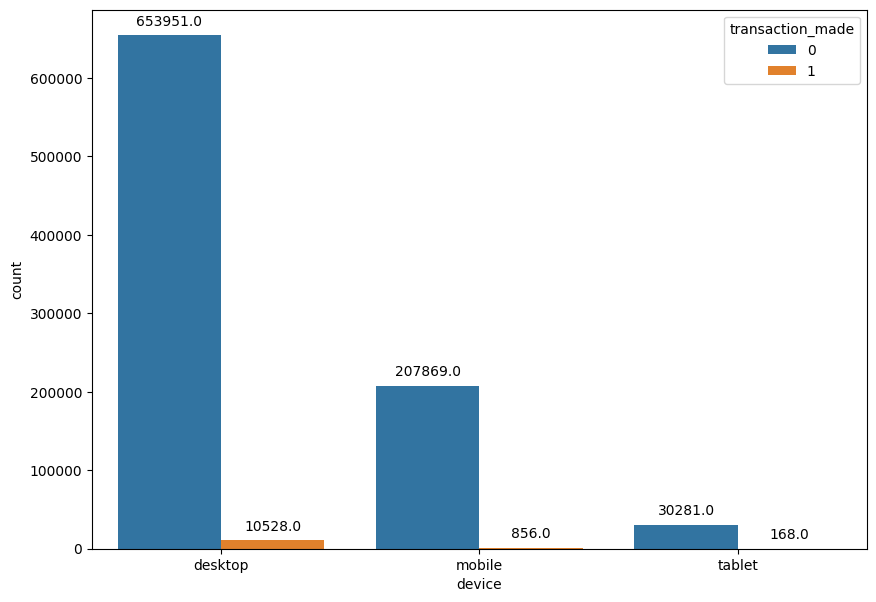

In [ ]:
#list for columns heights
heights=[]

#Plot figure
plt.figure(figsize=(10,7))
ax = sns.countplot(df,x="device",hue="transaction_made");
#Including heights above each column on countplot for better understanding
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    #Appending height of each column
    heights.append(p.get_height())
#Calculating and presenting percentage of transactions made on each device separately
print(f"Percentage of visits with transaction on desktops: { round(100*heights[3]/(heights[0]+heights[3]),3) }%")
print(f"Percentage of visits with transaction on mobile devices: { round(100*heights[4]/(heights[1]+heights[4]),3) }%")
print(f"Percentage of visits with transaction on tablets: { round(100*heights[5]/(heights[2]+heights[5]),3) }%")


There can be seen that people mostly use desktops during visits and what is more there is the biggest percentage of transactions on those devices.

**Trace connection between channel groupings and transaction making**

Percentage of visits with transaction using Direct channel: 1.441%
Percentage of visits with transaction using Display channel: 2.284%
Percentage of visits with transaction using Referral channel: 5.076%
Percentage of visits with transaction using Organic Search channel: 0.902%
Percentage of visits with transaction using Affiliates channel: 0.055%
Percentage of visits with transaction using Paid Search channel: 1.852%
Percentage of visits with transaction using Social channel: 0.046%
Percentage of visits with transaction using (Other) channel: 0.833%


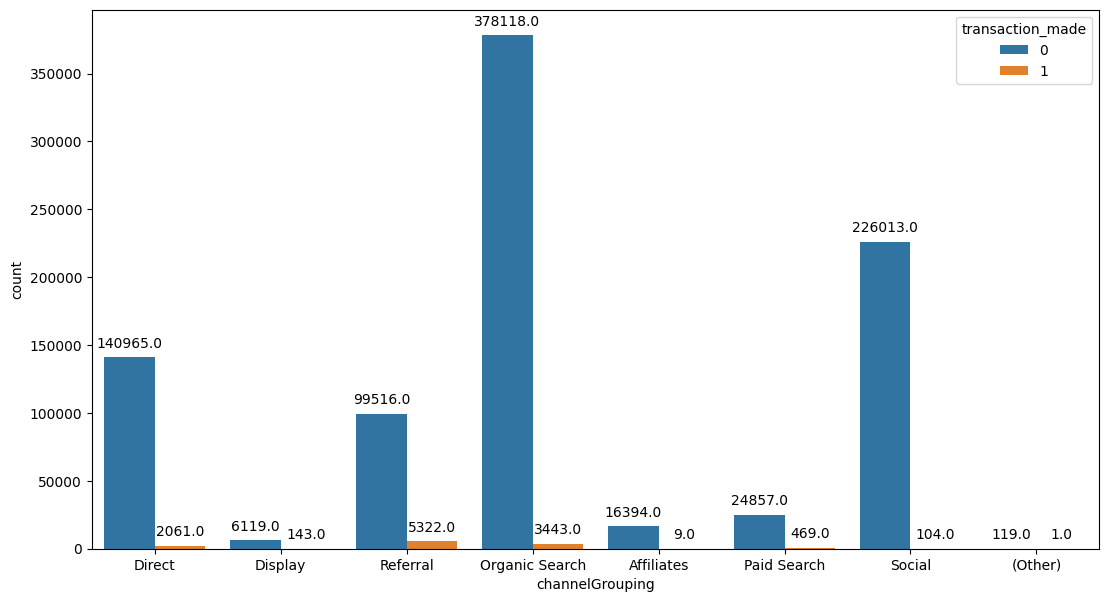

In [ ]:
#list for columns heights
heights=[]
plt.figure(figsize=(13,7))
ax = sns.countplot(df,x="channelGrouping",hue="transaction_made");
#Including heights above each column on countplot for better understanding
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    #Appending height of each column
    heights.append(p.get_height())
#Getting channels names
channel_groupings = df["channelGrouping"].unique()
#Calculating and presenting percentage of transactions made by other channels
for i,val in enumerate(channel_groupings):
  print(f"Percentage of visits with transaction using {val} channel: {round( 100*heights[i+8] / (heights[i+8]+heights[i]) ,3)}%")

There can be seen that there is some relation between channels and transaction making. Referral channels are noticeably more effective than others. Also Paid Search, Direct and Display distinguish from others.

**Trace connection between countries and transaction making**

In [ ]:
#List that will be used to create dataset containing country / ratio / num_of_visits
country_transaction=[]
#Code to fill dataset with percentage of transactions made to all transactions by countries
for country in df['country'].unique():
    country_df = df[df['country'] == country]#taking each country
    ratio = 100*country_df[country_df['transaction_made'] == 1]['transaction_made'].count() / len(country_df)#Calculate ratio -> percentage
    country_transaction.append({'country': country, 'percentage of transactions made to all transactions by countries': ratio, 'num_of_visits' : len(country_df)})#Fill list with data for dataset below
country_transaction_df = pd.DataFrame(country_transaction)
country_transaction_df.sort_values(by = "num_of_visits",ascending=False).head(25).sort_values(by = "percentage of transactions made to all transactions by countries",ascending=False)

,country,percentage of transactions made to all transactions by countries,num_of_visits
0,United States,3.012798,364744
12,Canada,0.738335,25869
13,Mexico,0.151229,13225
1,Taiwan,0.146199,12996
2,Singapore,0.139431,7172
19,Indonesia,0.118624,9273
11,Australia,0.102378,12698
37,Ireland,0.092407,6493
15,Japan,0.086159,19731
17,Brazil,0.050548,19783


There is some relation beetwen making transaction and country. It can be seen especially looking at USA and CANADA.

In [ ]:
#Drop Anguilla ans St.Lucia for better visualization 
country_transaction_df = country_transaction_df.drop(index=[194, 219])

In [ ]:
#Heatmap of percentage of made transaction to all transaction by geo location
fig = go.Figure(data=go.Choropleth(
    locations=country_transaction_df['country'], 
    z = country_transaction_df['ratio'].astype(float),
    locationmode = 'country names', 
    colorscale = 'speed',
    colorbar_title = "Percentage",
))
fig.update_layout(title_text = 'Percentage of made transaction to all transaction by geo location')
fig.show(renderer="colab")

# 2 Building model / Training / Predictions

##Preparing data for training

In [ ]:
#Dropping transactions as transaction_made is ylabel and those who I consider after data exploratory as useless in this case.
X = df.drop(["fullVisitorId","date","transactions","transaction_made" ],axis=1)
y = df["transaction_made"]
X.head()

,visitStartTime,bounces,timeOnSite,pageviews,num_of_hits,is_first_visit,device,country,source,channelGrouping
0,1494973097,0,385,11,15,1,mobile,United Kingdom,google,Organic Search
1,1494992652,0,2415,15,15,0,desktop,United States,analytics.google.com,Referral
2,1494945149,0,2678,10,15,1,desktop,United States,(direct),Referral
3,1494960798,0,598,13,15,1,desktop,United States,(direct),Referral
4,1494984118,0,496,14,15,1,desktop,Japan,google.co.jp,Referral


One hot encode categorical data

In [ ]:
X_one_hot = X.copy()
X_one_hot = pd.get_dummies(X_one_hot,columns=["device","country","source","channelGrouping"])
X_one_hot.head()

,visitStartTime,bounces,timeOnSite,pageviews,num_of_hits,is_first_visit,device_desktop,device_mobile,device_tablet,country_(not set),...,source_yandex,source_youtube.com,channelGrouping_(Other),channelGrouping_Affiliates,channelGrouping_Direct,channelGrouping_Display,channelGrouping_Organic Search,channelGrouping_Paid Search,channelGrouping_Referral,channelGrouping_Social
0,1494973097,0,385,11,15,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1494992652,0,2415,15,15,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1494945149,0,2678,10,15,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1494960798,0,598,13,15,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1494984118,0,496,14,15,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Dividing data to train/test splits

In [ ]:
X_trains,X_tests,y_trains,y_tests = train_test_split(X_one_hot,y,test_size=0.2,random_state=42)

Scaling data 
- Note: There is no need to scale data using Forests, but it also do not impact negatively.

In [ ]:
#Using standard scaler
scaler=StandardScaler()
X_trains_scaled = scaler.fit_transform(X_trains)
X_tests_scaled = scaler.transform(X_tests)

In [ ]:
len(X_trains_scaled),len(X_tests_scaled),len(y_trains),len(y_tests)

(722922, 180731, 722922, 180731)

##Baseline model - as baseline use DecisionTreeClassiffier without any hyperparameters changes

Train baseline model and predict

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_trains_scaled, y_trains)

DecisionTreeClassifier()

In [ ]:
y_pred = clf.predict(X_tests_scaled)

Evaluate baseline model

ROC curve represents true posivites rate vs false positives rate. Due to imbalanced dataset which can cause numerous false positives, this will be metric used to evaluate models. 

In [ ]:
roc_auc = roc_auc_score(y_tests, y_pred)
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.6712450502112254


In [ ]:
#Check classification report which shows if there is problem with false positives or negatives 
print(classification_report(y_tests,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    178359
           1       0.35      0.35      0.35      2372

    accuracy                           0.98    180731
   macro avg       0.67      0.67      0.67    180731
weighted avg       0.98      0.98      0.98    180731



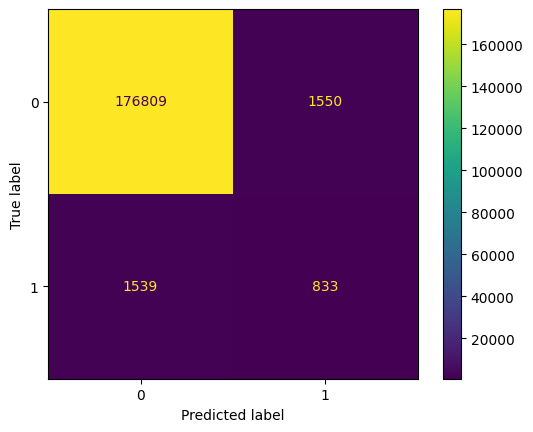

In [ ]:
#Create confusion matrix to check number of false positives and false negatives
cm = confusion_matrix(y_tests, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
disp.plot()

**As supposed there is huge problem with false positives due to the fact that there is enormous imbalance which was shown during data exploratory. Let's try to beat this model**

##Main model/s - considering imbalanced dataset and tune hyperparameters

###Model with roc_auc as scoring
- Using Grid Search and Cross Validation to choose better values of hyperparameters

In [ ]:
rfc = RandomForestClassifier()
#Parameters for GridSearch
grid_params = {
    'class_weight':['balanced'],
    'max_depth':[None,5],
    #'min_samples_split':[2,4,8],
    #'min_samples_leaf': [1, 2],    
    'n_estimators': [50,100]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Creating and fitting model
grid_model1 = GridSearchCV(rfc, param_grid=grid_params, cv=cv,scoring='roc_auc')
grid_model1.fit(X_trains_scaled, y_trains)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'], 'max_depth': [5],
                         'n_estimators': [100]},
             scoring='roc_auc')

In [ ]:
#Check what parameters were calculated as the best
grid_model1.best_params_

{'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 100}

In [ ]:
#Make predictions
grid_predicts = grid_model1.predict(X_tests_scaled)

In [ ]:
roc_auc1 = roc_auc_score(y_tests, grid_predicts)
print(f"ROC AUC: {roc_auc1}")

ROC AUC: 0.9487099248819362


In [ ]:
#Check classification report which shows if there is problem with false positives or negatives 
print(classification_report(y_tests,grid_predicts))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95    178423
           1       0.12      0.99      0.22      2308

    accuracy                           0.91    180731
   macro avg       0.56      0.95      0.58    180731
weighted avg       0.99      0.91      0.94    180731



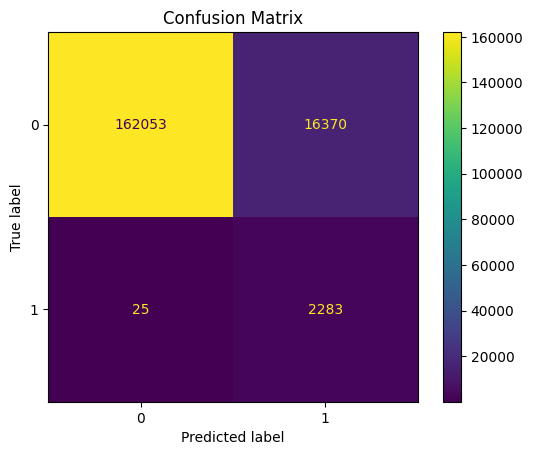

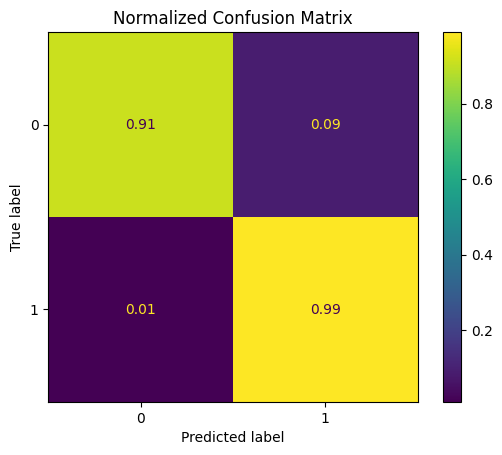

In [ ]:
#Create confusion matrix to check number of false positives and false negatives
cm = confusion_matrix(y_tests, grid_predicts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Confusion Matrix");

#Create normalized confusion matrix
cm = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();
disp.ax_.set_title("Normalized Confusion Matrix");

This model noticeably beats baseline, try to use another scoring and based on chosen values of hyperparameters try to see another values of hyperparameters, which can even beat this results.

###Model with f1_macro as scoring

In [ ]:
rfc = RandomForestClassifier()
#Fill parameters to compare during training and to choose best ones 
grid_params = {
    'class_weight':['balanced'],
    'max_depth':[5,10],
    #'min_samples_split':[2,4,8],
    #'min_samples_leaf': [1, 2],   
    'n_estimators': [100,128]
}
#Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Build and fit model
grid_model = GridSearchCV(rfc, param_grid=grid_params, cv=cv,scoring='f1_macro')
grid_model.fit(X_trains_scaled, y_trains)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'], 'max_depth': [10],
                         'n_estimators': [100]},
             scoring='f1_macro')

In [ ]:
#Check what parameters were calculated as the best
grid_model.best_params_

{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}

In [ ]:
#Make predictions
grid_predicts_f1 = grid_model.predict(X_tests_scaled)

In [ ]:
roc_auc = roc_auc_score(y_tests, grid_predicts_f1)
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.953005314100269


In [ ]:
#Check classification report which shows if there is problem with false positives or negatives 
print(classification_report(y_tests,grid_predicts_f1))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96    178423
           1       0.14      0.98      0.25      2308

    accuracy                           0.92    180731
   macro avg       0.57      0.95      0.61    180731
weighted avg       0.99      0.92      0.95    180731



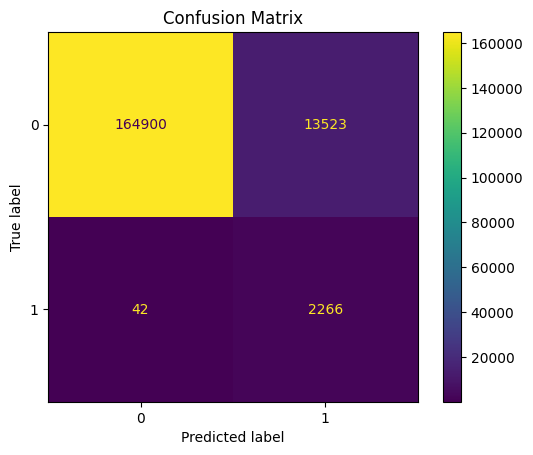

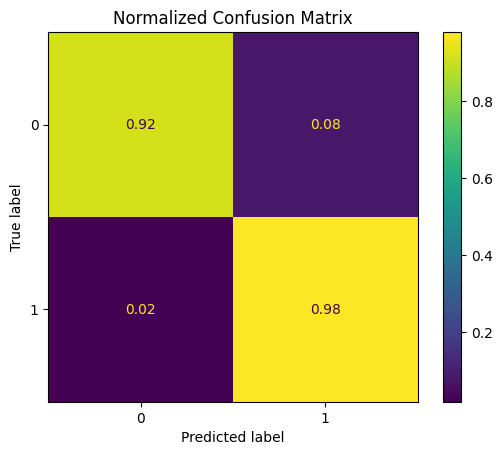

In [ ]:
#Create confusion matrix to check number of false positives and false negatives
cm = confusion_matrix(y_tests, grid_predicts_f1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Confusion Matrix");

#Create normalized confusion matrix
cm = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();
disp.ax_.set_title("Normalized Confusion Matrix");

In [ ]:
best_model = grid_model.best_estimator_
best_model

RandomForestClassifier(class_weight='balanced', max_depth=10)

That model gave the best results, that's why will be considered as target (end) model

# 3 Discover the most important features or combination of features that indicate a user will return.

- I suppose that the best way to discover those features is to analyse features from appropriate, trained model (in this case model that will predict if session is the first one for customer or not).
- By analysing those features I mean extracting those features and comparing impact made on models' decision.
- That's why I will make some analysis to check exactly for example which countries are better than others (in case of number of visit), but I will also train model for predicting if session is first visit or not, based on features given.

**Sorted correlations between is_first_visit and continuous data**

<ipython-input-34-a8376173eafb>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



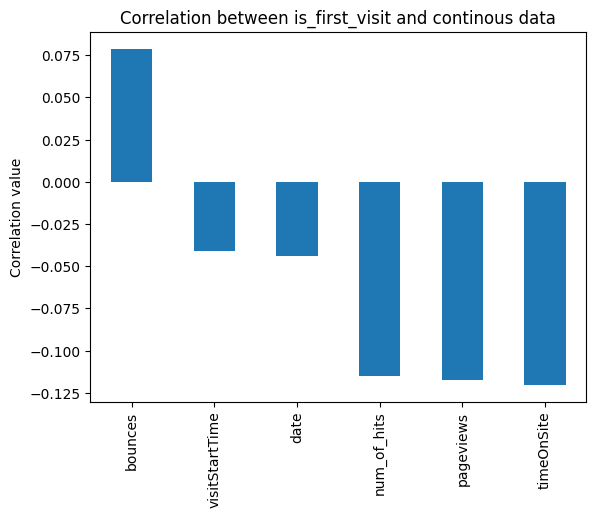

In [ ]:
#Take correlation betwwen is_first_visit and rest continuous data except from transactions
ax = df.drop(["transaction_made","transactions"],axis=1).corr()["is_first_visit"].sort_values(ascending=False)[1:].plot(kind='bar');
ax.set_title("Correlation between is_first_visit and continous data");
ax.set_ylabel("Correlation value");

**Percent of visits that are not first to all visits**

In [ ]:
no_first = df["is_first_visit"].value_counts()[0]
first = df["is_first_visit"].value_counts()[1]
visit_percent = 100*no_first / (no_first+first)

print(f"Percentage of not first visits: {round(visit_percent,3)}%\nNumber of not first visits: {no_first}\nNumber of first visits: {first}")


Percentage of not first visits: 22.198%
Number of not first visits: 200593
Number of first visits: 703060


There is also imbalance in those visits, not as big as previously with transactions, but still imbalance is noticeable.

**Trace connection between device and is_first_visit**

Percentage of visit not being first on desktops: 20.728%
Percentage of visit not being first on mobile devices: 22.731%
Percentage of visit not being first on tablets: 20.651%


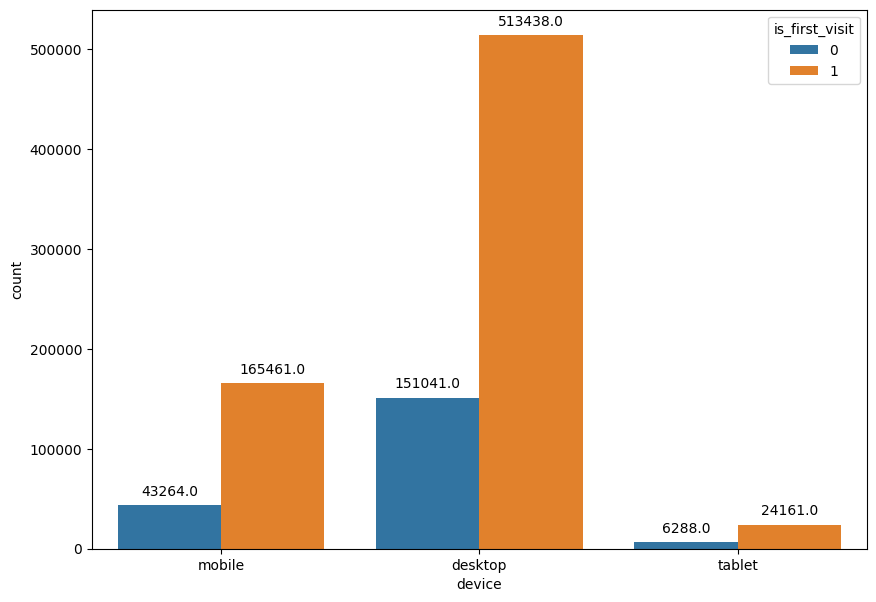

In [ ]:
#list for columns heights
heights=[]

#Plot figure
plt.figure(figsize=(10,7))
ax = sns.countplot(df,x="device",hue="is_first_visit");
#Including heights above each column on countplot for better understanding
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    #Appending height of each column
    heights.append(p.get_height())
#Calculating and presenting percentage of transactions made on each device separately
print(f"Percentage of visit not being first on desktops: { round(100*heights[0]/(heights[0]+heights[3]),3) }%")
print(f"Percentage of visit not being first on mobile devices: { round(100*heights[1]/(heights[1]+heights[4]),3) }%")
print(f"Percentage of visit not being first on tablets: { round(100*heights[2]/(heights[2]+heights[5]),3) }%")


**Trace connection between channelGrouping and is_first_visit**

Percentage of visit not being first using Organic Search channel: 20.686%
Percentage of visit not being first using Referral channel: 49.098%
Percentage of visit not being first using Direct channel: 25.297%
Percentage of visit not being first using Paid Search channel: 37.764%
Percentage of visit not being first using Social channel: 7.107%
Percentage of visit not being first using Display channel: 70.026%
Percentage of visit not being first using Affiliates channel: 23.746%
Percentage of visit not being first using (Other) channel: 79.167%


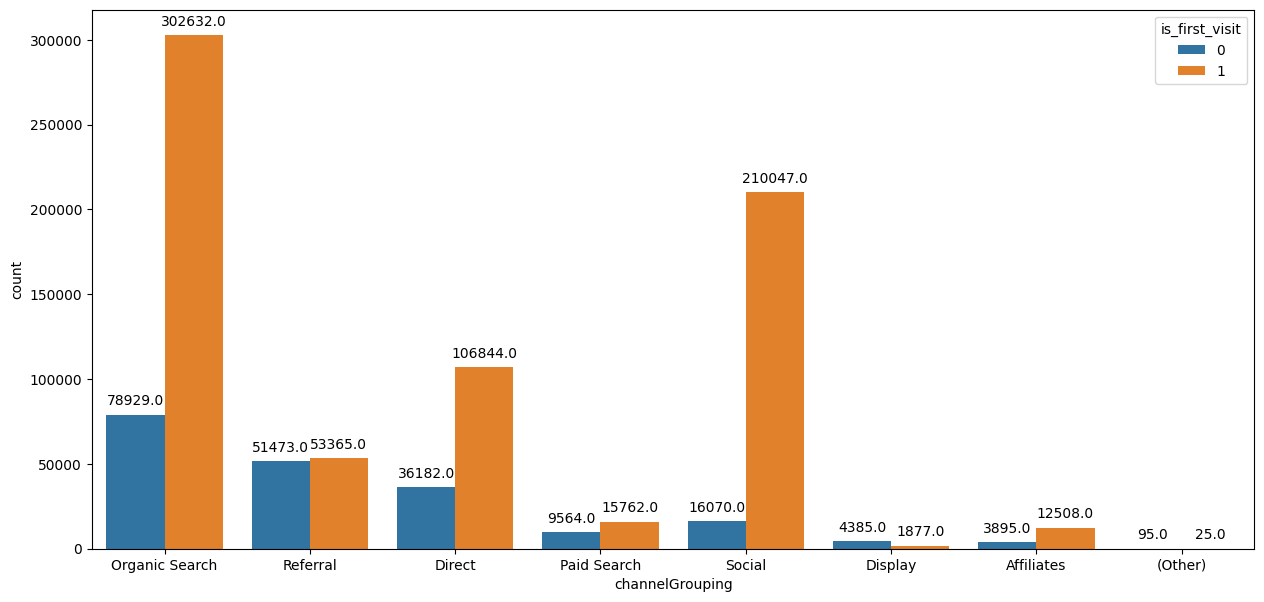

In [ ]:
#list for columns heights
heights=[]
plt.figure(figsize=(15,7))
ax = sns.countplot(df,x="channelGrouping",hue="is_first_visit");
#Including heights above each column on countplot for better understanding
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    #Appending height of each column
    heights.append(p.get_height())
#Getting channels names
channel_groupings = df["channelGrouping"].unique()
#Calculating and presenting percentage of transactions made by other channels
for i,val in enumerate(channel_groupings):
  print(f"Percentage of visit not being first using {val} channel: {round( 100*heights[i] / (heights[i+8]+heights[i]) ,3)}%")

**Trace connection between countries and is_first_visit**

In [ ]:
#List that will be used to create dataset containing country / ratio / num_of_visits
country_visits=[]
#Code to fill dataset with percentage of not first visit to all visits by countries
for country in df['country'].unique():
    country_df = df[df['country'] == country]#taking each country
    ratio = 100*country_df[country_df['is_first_visit'] == 0]['is_first_visit'].count() / len(country_df)#Calculate ratio -> percentage
    country_visits.append({'country': country, 'percentage of not first visit to all visits': ratio, 'num_of_visits' : len(country_df)})#Fill list with data for dataset below
country_visits_df = pd.DataFrame(country_visits)
#Present 20 countries sorted by bbiggest number of visits and then by percentage of not first visit to all visits
country_visits_df.sort_values(by = "num_of_visits",ascending=False).head(20).sort_values(by = "percentage of not first visit to all visits",ascending=False)

,country,percentage of not first visit to all visits,num_of_visits
0,United States,33.626873,364744
12,Canada,26.591673,25869
1,Taiwan,24.738381,12996
14,France,20.546993,15832
9,Spain,20.346543,11658
15,Japan,19.203284,19731
6,Netherlands,17.593644,11453
41,Poland,16.455174,9693
4,United Kingdom,16.080550,37393
22,Italy,15.407695,11332


**Trace connection between sources and is_first_visit**

In [ ]:
#List that will be used to create dataset containing country / ratio / num_of_visits
source_visits=[]
#Code to fill dataset with percentage of not first visit to all visits by countries
for source in df['source'].unique():
    source_df = df[df['source'] == source]#taking each source
    ratio = 100*source_df[source_df['is_first_visit'] == 0]['is_first_visit'].count() / len(source_df)#Calculate ratio -> percentage
    source_visits.append({'source': source, 'percentage of not first visit to all visits': ratio, 'num_of_visits' : len(source_df)})#Fill list with data for dataset below
source_visits_df = pd.DataFrame(source_visits)
#Present 20 sources sorted by biggest number of visits and then by percentafe of not first visit 
source_visits_df.sort_values(by = "num_of_visits",ascending=False).head(20).sort_values(by = "percentage of not first visit to all visits",ascending=False)

,source,percentage of not first visit to all visits,num_of_visits
5,dfa,73.091804,5686
11,mail.google.com,71.654084,1457
9,sites.google.com,64.532350,2983
29,groups.google.com,46.146341,1025
6,analytics.google.com,42.759090,16172
7,facebook.com,39.155052,2296
1,(direct),29.474599,371469
16,quora.com,28.331177,1546
13,reddit.com,25.568744,2022
8,Partners,23.746268,16411


##Build model and extract, analyse features impacts on its decision

###Prepare data

Create X and y sets

In [ ]:
X_visit = df.drop(["fullVisitorId","date","transactions","transaction_made","is_first_visit"],axis=1)
y_visit = df["is_first_visit"]

Use label encoding - as there is purpose to extract features. One-hot created about 500 columns for model training in 2 point

In [ ]:
labelencoder = LabelEncoder()
#Copy X dataset
X_label_encode = X_visit.copy()

#Label encode categorical data
X_label_encode["device"] = labelencoder.fit_transform(X_label_encode["device"])
X_label_encode["source"] = labelencoder.fit_transform(X_label_encode["source"])
X_label_encode["channelGrouping"] = labelencoder.fit_transform(X_label_encode["channelGrouping"])
X_label_encode["country"] = labelencoder.fit_transform(X_label_encode["country"])

X_label_encode.head()

,visitStartTime,bounces,timeOnSite,pageviews,num_of_hits,device,country,source,channelGrouping
0,1497455649,0,129,8,14,0,212,77,4
1,1497456388,0,641,13,14,1,196,77,4
2,1497476332,0,385,12,14,0,212,0,6
3,1497463936,0,168,10,14,0,212,77,4
4,1497462978,0,687,10,14,1,212,77,4


In [ ]:
X_oh = X_visit.copy()
X_oh = pd.get_dummies(X_oh,columns=["device","country","source","channelGrouping"])
X_t,X_te,y_t,y_te = train_test_split(X_oh,y_visit,test_size=0.2,random_state=42)

Divide on train and test sets

In [ ]:
X_trains_v,X_tests_v,y_trains_v,y_tests_v = train_test_split(X_label_encode,y_visit,test_size=0.2,random_state=42)

In [ ]:
y_trains_v.value_counts(),y_tests_v.value_counts()

(1    562585
 0    160337
 Name: is_first_visit, dtype: int64,
 1    140475
 0     40256
 Name: is_first_visit, dtype: int64)

###Build model

In [ ]:
rfc = RandomForestClassifier()
grid_params = {
    'class_weight':['balanced'],
    'max_depth':[10], 
    'n_estimators': [100]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

visits_model = GridSearchCV(rfc, param_grid=grid_params, cv=cv,scoring='f1_macro')
visits_model.fit(X_trains_v, y_trains_v)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced'], 'max_depth': [10],
                         'n_estimators': [100]},
             scoring='f1_macro')

In [ ]:
visits_predicts = visits_model.predict(X_tests_v)

Evaluate with roc_auc_score and confusion matrix

In [ ]:
roc_auc = roc_auc_score(y_tests_v, visits_predicts)
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.6789469572171808


In [ ]:
#Check classification report which shows if there is problem with false positives or negatives 
print(classification_report(y_tests_v,visits_predicts))

              precision    recall  f1-score   support

           0       0.38      0.68      0.49     40256
           1       0.88      0.68      0.77    140475

    accuracy                           0.68    180731
   macro avg       0.63      0.68      0.63    180731
weighted avg       0.77      0.68      0.70    180731



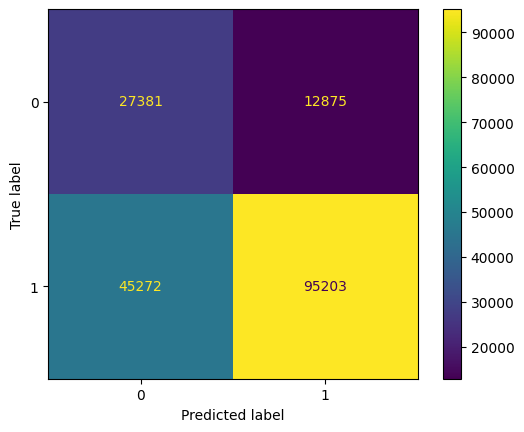

In [ ]:
#Create confusion matrix to check number of false positives and false negatives
cm = confusion_matrix(y_tests_v, visits_predicts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

**Thoughts**
- This model didn't achieve as good results as main model created to predict purchases. Nevertheless this model was made in purpose to help me gain some knowledge about importance of features in case of customer returning, not beating some increadible results. I can say it was model made as appendix, that is why I haven't tried to beat it (also time is ending). ROC is about 68%, so as accuracy, so this model is making some reasonable decision, not just randomly guessing.  
- Of course if there would be better results, I suppose that importance of features could be more precise.

###Extract features and analyse impact on decision wheter is session first or no.

In [ ]:
#Taking model from gridSearch
best_visits_model = visits_model.best_estimator_
best_visits_model

RandomForestClassifier(class_weight='balanced', max_depth=10)

**Extracting features from trained model and check how important each of them are**

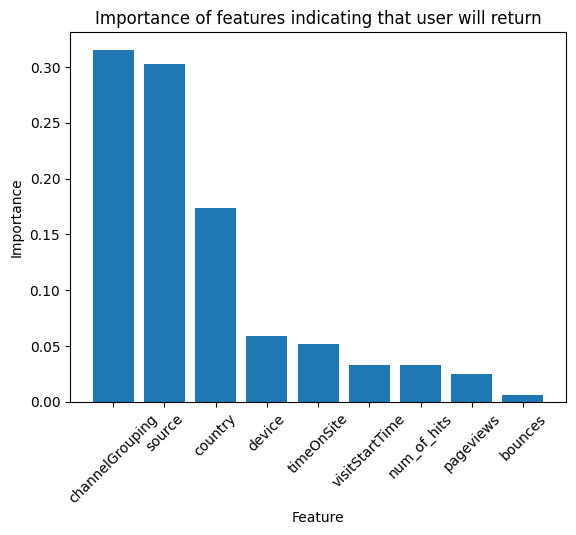

In [ ]:
#Getting importance measures
importances = best_visits_model.feature_importances_

#Sorting features by their importances
indices = np.argsort(importances)[::-1]
sorted_features = X_trains_v.columns[indices]
sorted_importances = importances[indices]

#Plotting
plt.bar(sorted_features, sorted_importances)
plt.xticks(rotation=45)
plt.title("Importance of features indicating that user will return")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()